In [1]:
import math
from pathlib import Path

import numpy as np
from scipy import optimize

from astropy.table import QTable, Table
from astropy.io import fits
from astropy.coordinates import SkyCoord

from astropy import units as u

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
phat_tab = QTable.read('hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_12110-m31-b19_f275w-f336w-f475w-f814w-f110w-f160w_v2_st.fits')
phat_tab['coord'] = SkyCoord.guess_from_table(phat_tab, unit='deg')
phat_tab

x,y,ra,dec,f110w_rate,f110w_raterr,f110w_vega,f110w_err,f110w_chi,f110w_snr,f110w_sharp,f110w_round,f110w_crowd,f110w_flag,f160w_rate,f160w_raterr,f160w_vega,f160w_err,f160w_chi,f160w_snr,f160w_sharp,f160w_round,f160w_crowd,f160w_flag,f275w_rate,f275w_raterr,f275w_vega,f275w_err,f275w_chi,f275w_snr,f275w_sharp,f275w_round,f275w_crowd,f275w_flag,f336w_rate,f336w_raterr,f336w_vega,f336w_err,f336w_chi,f336w_snr,f336w_sharp,f336w_round,f336w_crowd,f336w_flag,f475w_rate,f475w_raterr,f475w_vega,f475w_err,f475w_chi,f475w_snr,f475w_sharp,f475w_round,f475w_crowd,f475w_flag,f814w_rate,f814w_raterr,f814w_vega,f814w_err,f814w_chi,f814w_snr,f814w_sharp,f814w_round,f814w_crowd,f814w_flag,f275w_gst,f336w_gst,f475w_gst,f814w_gst,f110w_gst,f160w_gst,field,ir_x,ir_y,inside_ir,inside_brick,inside_chipgap,inside_other_chipgap,coord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bool,bool,bool,bool,bool,bool,int64,float32,float32,bool,bool,bool,bool,SkyCoord
2594.8,3361.66,11.580036786094919,42.088067163048244,6.5e-06,6.22e-10,12.969,0.0,0.48,10434.8,-0.003,-0.008,0.001,0,1.11e-05,1.08e-09,12.389,0.0,0.65,10232.6,0.034,0.002,0.0,0,2.92e-08,1.95e-10,18.838,0.007,1.35,149.9,-0.013,0.028,0.0,0,2.94e-07,5.55e-10,16.329,0.002,0.85,529.7,-0.021,0.015,0.0,0,8.67e-07,1.99e-09,15.155,0.002,2.99,435.3,-0.046,0.06,0.0,0,0.0,9999.0,99.999,9.999,0.0,0.0,0.0,0.0,0.0,0,True,True,True,True,True,True,1,991.81635,706.9716,True,True,False,False,"11.580036786094919,42.088067163048244"
2726.61,1923.46,11.603287760928435,42.098294951116664,1e-06,2.6e-10,15.0,0.0,0.95,3842.8,0.027,0.0,0.075,0,1.4e-06,4.24e-10,14.632,0.0,1.12,3307.5,0.034,0.017,0.11,0,3.91e-08,2.28e-10,18.52,0.006,1.98,171.7,0.027,0.035,0.014,0,1.94e-07,4.57e-10,16.78,0.003,2.13,424.6,0.07,0.072,0.006,0,2.73e-07,1.15e-09,16.41,0.005,4.82,236.8,-0.079,0.087,0.005,0,8.16e-07,2.14e-09,15.221,0.003,1.79,380.5,-0.003,0.059,0.006,0,True,True,True,True,True,True,1,654.772,245.6434,True,True,False,False,"11.603287760928435,42.098294951116664"
1228.87,2331.91,11.580653944770967,42.11181945656603,8.82e-07,2.31e-10,15.136,0.0,0.85,3815.3,0.001,-0.011,0.015,0,1.53e-06,4.06e-10,14.538,0.0,0.73,3768.5,0.018,0.009,0.015,0,1.06e-08,1.23e-10,19.939,0.013,2.47,86.2,0.0,0.005,0.0,0,7.44e-08,1.85e-10,17.82,0.003,2.68,401.9,0.038,0.047,0.0,0,1.32e-07,8.01e-10,17.195,0.007,3.24,165.4,-0.07,0.005,0.0,0,5.5e-07,1.99e-09,15.649,0.004,2.11,276.0,-0.001,-0.027,0.0,2,True,True,True,True,True,True,1,365.55856,800.8013,True,True,False,False,"11.580653944770967,42.11181945656603"
2332.32,3502.88,11.575015071160772,42.089869674165655,6.19e-07,1.92e-10,15.521,0.0,1.02,3222.0,-0.001,-0.011,0.002,0,9.22e-07,3.13e-10,15.088,0.0,0.8,2943.5,0.003,0.002,0.002,0,5.28e-08,4.66e-10,18.193,0.01,1.4,113.4,-0.045,0.034,0.0,0,1.55e-07,2.66e-10,17.022,0.002,1.83,583.9,-0.042,0.052,0.0,0,1.64e-07,8.78e-10,16.965,0.006,2.67,186.4,-0.061,0.029,0.0,0,4.66e-07,1.62e-09,15.83,0.004,1.73,287.8,0.011,0.021,0.0,0,True,True,True,True,True,True,1,959.1338,824.74756,True,True,False,False,"11.575015071160772,42.089869674165655"
2021.7,532.24,11.616652426284764,42.117551579875084,2.29e-07,1.2e-10,16.6,0.001,1.75,1909.3,-0.048,0.0,0.011,0,5.53e-07,2.49e-10,15.643,0.0,1.18,2219.8,0.014,-0.006,0.022,0,-3.1e-11,1.92e-11,99.999,9.999,1.11,-1.6,2.943,-0.311,0.0,0,7.76e-11,9.58e-12,25.275,0.134,1.19,8.1,0.013,-0.032,0.0,0,2.74e-09,8.46e-12,21.407,0.003,1.25,323.8,0.035,0.037,0.0,0,7.4e-08,6.21e-11,17.828,0.001,5.28,1190.5,-0.067,-0.009,0.0,0

In [4]:
ramin = np.min(phat_tab['coord'].ra)
ramax = np.max(phat_tab['coord'].ra)
decmin = np.min(phat_tab['coord'].dec)
decmax = np.max(phat_tab['coord'].dec)

center = SkyCoord(ra=(ramin + ramax)/2, dec=(decmin + decmax)/2)

In [5]:
from astroquery.gaia import Gaia

Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = 100000

In [6]:
gaia_tab_path = Path('gaia_table.ecsv')

if gaia_tab_path.is_file():
    gaia_tab = Table.read(str(gaia_tab_path), format='ascii.ecsv')
else:
    gaia_tab = Gaia.query_object_async(center, 
                                       width=ramax - ramin  + 2*u.arcmin, 
                                       height=decmax - decmin + 2*u.arcmin)
    gaia_tab.write(str(gaia_tab_path), format='ascii.ecsv')
    
gaia_tab['coord'] = SkyCoord(ra=gaia_tab['ra'], dec=gaia_tab['dec'])
gaia_tab['radec_error'] = (gaia_tab['ra_error'].quantity**2 + gaia_tab['dec_error'].quantity**2)**0.5
gaia_tab

dist,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,coord,radec_error
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,"deg,deg",mas
float64,int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,fl

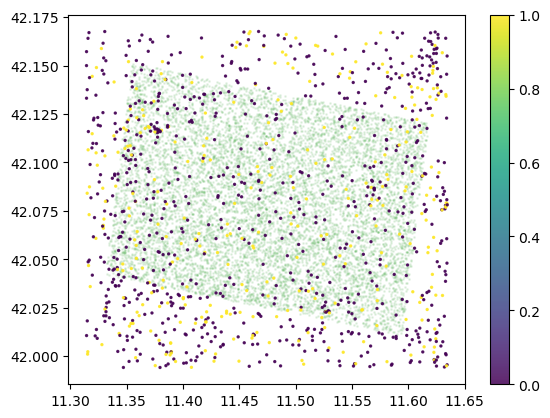

In [7]:
smaller_phat_tab = phat_tab[np.random.permutation(len(phat_tab))[:10000]]

plt.scatter(smaller_phat_tab['coord'].ra.deg, smaller_phat_tab['coord'].dec.deg, s=1, alpha=.1, c= 'C2')


plt.scatter(gaia_tab['ra'], gaia_tab['dec'], s=2, alpha=.85, c=gaia_tab['radec_error']>2*u.marcsec)
plt.colorbar()


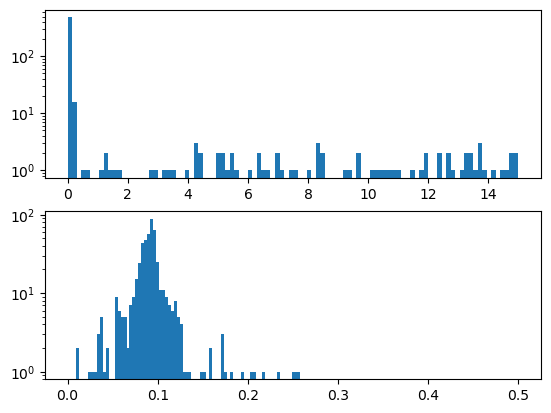

In [8]:
match, sep, _ = gaia_tab['coord'].match_to_catalog_sky(phat_tab['coord'])

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(sep.arcsec,range=(0, 15), bins=100, log=True)
ax2.hist(sep.arcsec,range=(0, .5), bins='auto', log=True);

(<Angle 119.45054871 marcsec>,
 <Angle -18.08578176 marcsec>,
 <Angle 120.81195756 marcsec>)

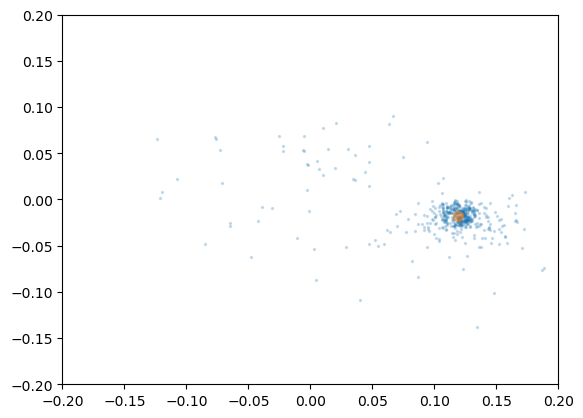

In [9]:
dra = gaia_tab['coord'].ra - phat_tab['coord'].ra[match]
ddec = gaia_tab['coord'].dec - phat_tab['coord'].dec[match]

dramed = np.median(dra[np.abs(dra.arcsec)<.2])
ddecmed = np.median(ddec[np.abs(ddec.arcsec)<.2])

plt.scatter(dra.arcsec, ddec.arcsec, alpha=.2, s=2)
plt.scatter([dramed.arcsec], [ddecmed.arcsec], alpha=.5, s=50)
plt.xlim(-.2, .2)
plt.ylim(-.2, .2)
dramed.to(u.marcsec),ddecmed.to(u.marcsec), np.hypot(dramed, ddecmed).to(u.marcsec)

(335, 1107)

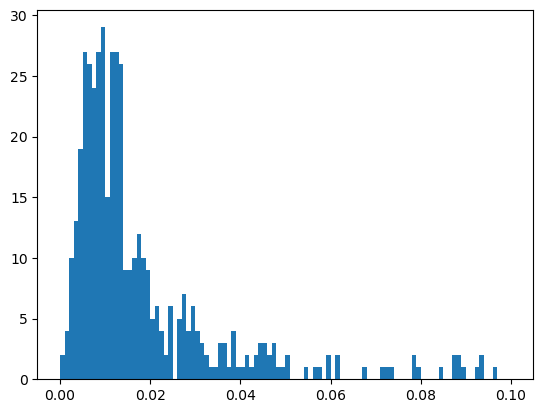

In [11]:
sepmed = np.hypot(dra - dramed, ddec - ddecmed)

plt.hist(sepmed.arcsec, range=(0,.1), bins=100)
good_matches = sepmed.arcsec < .02
np.sum(good_matches), len(good_matches)

# Check whether rotation helps

In [12]:
gaia_match_tab = gaia_tab[good_matches]
phat_match_tab = phat_tab[match[good_matches]]

In [13]:
xp = phat_match_tab['coord'].ra.deg
yp = phat_match_tab['coord'].dec.deg
xg = gaia_match_tab['coord'].ra.deg
yg = gaia_match_tab['coord'].dec.deg

def f(p, inclrot=True):
    raoff, decoff, rotdeg = p
    rotrad = math.radians(rotdeg)
    
    #shifts above have sign of phat + offset = gaia
    # do rotation on phat *then* offsets so that offsets are gaia-frame-aligned
    
    c = math.cos(rotrad)
    s = math.sin(rotrad)
    if not inclrot:
        c=1
        s=0
        
    xprot = xp*c - yp*s
    yprot = xp*s + yp*c
    
    
    xptransformed = xprot + raoff
    yptransformed = yprot + decoff
    
    return np.hypot(xptransformed-xg, yptransformed-yg)

res = optimize.least_squares(f, [float(dramed.deg), float(ddecmed.deg), 0])
bestraoff, bestdecoff, bestrotdeg = [e*u.deg for e in res.x]
bestraoff.to(u.marcsec), bestdecoff.to(u.marcsec), bestrotdeg

(<Quantity 119.44178393 marcsec>,
 <Quantity -17.02002585 marcsec>,
 <Quantity -1.37582499e-07 deg>)

Rotation does not change the answer!

# Final answer saved in intermediate file for other notebooks:

In [14]:
import json

In [16]:
tosave = {'description':'offsets to add to the phat catalog to put it on the Gaia DR3 frame',
          'ra_to_add_to_phat_deg':dramed.to(u.deg).value,
          'dec_to_add_to_phat_deg': ddecmed.to(u.deg).value
         }

with open('phat_astrom_correction.json', 'w') as f:
    json.dump(tosave, f)